# Load Essential Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import transformers
transformers.logging.set_verbosity_error()
from transformers import BertTokenizer
from transformers import BertModel

from IPython.display import clear_output
import os
import numpy as np
import pandas as pd
import random
import json
from tqdm import tqdm
from sklearn import metrics
import time
from sklearn.model_selection import train_test_split

2023-08-29 14:44:43.416591: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 14:44:43.502697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 14:44:44.535213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Set up GPU for training

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3090


# Load Data

In [4]:
#read train file
df_train = pd.read_csv(f'simple_CH_train.csv')
df_test = pd.read_csv(f'simple_CH_test.csv')

# data increment

In [5]:
import pandas as pd

def incremental_concat(df):
    df_copy = df.copy()
    df = pd.concat([df, df_copy], ignore_index=True)
    return df

df_train = incremental_concat(df_train)
df_train

,text1,text2,combined_text,label
0,每张配现金550元加17股比去年多配50元这样算好吗?如果全配现金就好了高雄银每张配现金六百...,外资买超三个月了，今天冲高卖超2000多张，后续要观察一下外资动作,配现金、股利、配股、稀释股本、股本扩张、外资、买超、冲高、卖超、观察,0
1,金融果然是最黑这样也能再爬回来,赞赞赞再来就等三宝案是否有还款,金融、黑、爬回来、三宝案、还款,0
2,"中寿从104年买进至今也三年了,三年间只有买进抱紧至今未实现部份40%,稳稳的成长.",单月eps0.76？ ？ ？有错请更正,"中寿、104年、买进、未实现部份、成长、单月EPS, 财经资讯, 0.76",0
3,"这支macd回到零轴上交叉明天大盘再涨也会回到零轴上交叉配合今晚国际股市收红,明天量能再放大...",如果回档不多，或横向移动，应该也不敢补了??,"macd, 零轴上交叉, 大盘, 国际股市, 超级法人、回档、横向移动、补仓、风险",0
4,发哥太猛了...,讨论前都是看高通入门~中高产品表现高通表现低，联发科高，反之亦然,股市、投资、景气、经济、金融、高通、联发科、产品表现、入门、低,0
...,...,...,...,...
13031,"观望中,如果第四季继续亏,净值跌破5元,变全额交割股就麻烦了.=========有可能啊",赌徒就是要坚强现有60支均价5.5预计凑到80支是上限当初只想买30支玩玩就好想不到坏消息愈...,"观望中,第四季,亏损,净值,跌破5元,全额交割股、赌徒、坚强、均价、80支、坏消息",2
13032,亚光也跌够深了今天终于有点小喷好现象其实我还是觉得苹果来看亚光绝对不是简单的事只是保密到家不...,纯粹论产业找那么多产业消息还被消遣也没关系谁赚多少跟产业真的也无关惟消遣后还是无法让亚光在混...,亚光，跌够深，小喷，苹果，保密、产业消息、赚多少、产业真的也无关、亚光、炒作,2
13033,美国司法部展开反垄断调查运费准备绰赛了.....,原来今天就是因为这个题材才使阳明突然大涨!!,反垄断，调查，运费，美国司法部，绰赛、阳明、大涨、题材、财经、原因,2
13034,群创今日股价已贴上月线7/28星期一为q2法说当q2财报公布时大家认为走势会如何呢?再加上7...,钱还完不代表可躺着赚钱还完反而要担心代表没有资本支出营运可能停滞不前应该是折旧降的越快越快躺...,"群创, 股价, 月线, Q2财报, 现金增资、还完、资本支出、停滞不前、折旧降速、躺着赚、Q...",2


In [6]:
df_train.reset_index(drop=True, inplace=True)
df_train

,text1,text2,combined_text,label
0,每张配现金550元加17股比去年多配50元这样算好吗?如果全配现金就好了高雄银每张配现金六百...,外资买超三个月了，今天冲高卖超2000多张，后续要观察一下外资动作,配现金、股利、配股、稀释股本、股本扩张、外资、买超、冲高、卖超、观察,0
1,金融果然是最黑这样也能再爬回来,赞赞赞再来就等三宝案是否有还款,金融、黑、爬回来、三宝案、还款,0
2,"中寿从104年买进至今也三年了,三年间只有买进抱紧至今未实现部份40%,稳稳的成长.",单月eps0.76？ ？ ？有错请更正,"中寿、104年、买进、未实现部份、成长、单月EPS, 财经资讯, 0.76",0
3,"这支macd回到零轴上交叉明天大盘再涨也会回到零轴上交叉配合今晚国际股市收红,明天量能再放大...",如果回档不多，或横向移动，应该也不敢补了??,"macd, 零轴上交叉, 大盘, 国际股市, 超级法人、回档、横向移动、补仓、风险",0
4,发哥太猛了...,讨论前都是看高通入门~中高产品表现高通表现低，联发科高，反之亦然,股市、投资、景气、经济、金融、高通、联发科、产品表现、入门、低,0
...,...,...,...,...
13031,"观望中,如果第四季继续亏,净值跌破5元,变全额交割股就麻烦了.=========有可能啊",赌徒就是要坚强现有60支均价5.5预计凑到80支是上限当初只想买30支玩玩就好想不到坏消息愈...,"观望中,第四季,亏损,净值,跌破5元,全额交割股、赌徒、坚强、均价、80支、坏消息",2
13032,亚光也跌够深了今天终于有点小喷好现象其实我还是觉得苹果来看亚光绝对不是简单的事只是保密到家不...,纯粹论产业找那么多产业消息还被消遣也没关系谁赚多少跟产业真的也无关惟消遣后还是无法让亚光在混...,亚光，跌够深，小喷，苹果，保密、产业消息、赚多少、产业真的也无关、亚光、炒作,2
13033,美国司法部展开反垄断调查运费准备绰赛了.....,原来今天就是因为这个题材才使阳明突然大涨!!,反垄断，调查，运费，美国司法部，绰赛、阳明、大涨、题材、财经、原因,2
13034,群创今日股价已贴上月线7/28星期一为q2法说当q2财报公布时大家认为走势会如何呢?再加上7...,钱还完不代表可躺着赚钱还完反而要担心代表没有资本支出营运可能停滞不前应该是折旧降的越快越快躺...,"群创, 股价, 月线, Q2财报, 现金增资、还完、资本支出、停滞不前、折旧降速、躺着赚、Q...",2


# 整理資料

In [7]:
#select only text, label
data_label = df_train["label"].values
y_train = df_train['label'].values
df_train = df_train[['text1','text2','combined_text']]
df_train.shape

(13036, 3)

# Fine-tuning BERT

In [8]:
MAX_LEN = 280
LEARNING_RATE = 2e-5

In [9]:
from transformers import BertTokenizer,BertTokenizerFast,AutoTokenizer, TFAutoModelForSequenceClassification, AutoModelForMaskedLM
# Load the BERT tokenizer

tokenizer = BertTokenizer.from_pretrained("hfl/chinese-macbert-large")

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    token_type_ids = []

    # For every sentence...
    for sent1, sent2, sent3 in zip(data['text1'].astype(str), data['text2'].astype(str), data['combined_text'].astype(str)):
        encoded_dict = tokenizer.encode_plus(
            sent1, sent2 + " [SEP] " + sent3,
            add_special_tokens=True,
            max_length=MAX_LEN,
            truncation_strategy='longest_first',
            return_attention_mask=True,
            return_tensors='pt',
            padding='max_length'
        )

        input_ids.append(encoded_dict['input_ids'].squeeze())
        attention_masks.append(encoded_dict['attention_mask'].squeeze())
        token_type_ids.append(encoded_dict['token_type_ids'].squeeze())

    input_ids = torch.stack(input_ids, dim=0)
    attention_masks = torch.stack(attention_masks, dim=0)
    token_type_ids = torch.stack(token_type_ids, dim=0)

    return input_ids, attention_masks, token_type_ids

train_inputs, train_masks,train_token_type_ids = preprocessing_for_bert(df_train)

/home/yoyolin/anaconda3/envs/env-pytorch2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2399: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(


In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)

# Create the DataLoader for our training set
batch_size = 16
train_data = TensorDataset(train_inputs, train_masks, train_token_type_ids,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Train Model

## Create BertClassifier

In [11]:
%%time
from transformers import BertModel, AutoModel,BertForSequenceClassification, AutoModelForTokenClassification, BertConfig

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, bert_model, freeze_bert=False):#改
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids = token_type_ids
                           )

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits
H = 24  # Example value for the hidden size
D_out = 3
bert_model = BertModel.from_pretrained("hfl/chinese-macbert-large")

CPU times: user 5.38 s, sys: 1.64 s, total: 7.02 s
Wall time: 7.83 s


## Optimizer & Learning Rate Scheduler

In [12]:
from transformers import AdamW, get_linear_schedule_with_warmup
Epochs = 4
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(bert_model)
    # bert_classifier = BertClassifier()

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = torch.optim.Adam(bert_classifier.parameters(), lr=LEARNING_RATE)
    # optimizer = torch.optim.AdamW(bert_classifier.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

## Training Loop

In [13]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot train loss
    ax.plot(train_loss, label='Train Loss')

    # Plot val loss
    ax.plot(val_loss, label='Val Loss')

    # Set labels and title
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')

    # Add legend
    ax.legend()
    # Show the plot
    plt.show()

In [14]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss() # No adjust weight
from sklearn.metrics import f1_score
# loss_fn = nn.CrossEntropyLoss(weight = torch.tensor(class_weights, dtype=torch.float)) # Adjust weight


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=Epochs, evaluation=False, save_best_model = True):
    """Train the BertClassifier model.
    """
    train_losses = []
    val_losses = []
    best_macro_f1 = 0.0
    best_val_loss = float('inf')
    
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Macro-F1':^9.2} | {'Elapsed':^9}")

        print("-"*80)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask, b_token_type_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9.2} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print("-"*80)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, macro_f1 = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                if save_best_model:
                    torch.save(model.state_dict(), f"./final_github/best{epoch_i}_model.pt")
            
            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
                if save_best_model:
                    torch.save(model.state_dict(), f"./final_github/best{epoch_i}_model.pt")
                    
            # Append train and val losses to the lists
            train_losses.append(avg_train_loss)
            val_losses.append(val_loss)
            
            print(f"{epoch_i + 1:^7} | {step:^7} | {avg_train_loss:^12f} | {val_loss:^10f} | {macro_f1:^9.2f} | {time_elapsed:^9f}")
            print("-" * 80)
            
        print("\n")

    print("Training complete!")
    plot_loss(train_losses, val_losses)
    return best_val_loss, best_macro_f1

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    
    model.eval()

    # Tracking variables
    val_loss = []
    val_predictions = []
    val_labels = []
    val_accuracy = []
    macro_f1 = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask, b_token_type_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        val_predictions.extend(preds.cpu().numpy())
        val_labels.extend(b_labels.cpu().numpy())
        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
        # Compute the macro F1 score
        macro_f1_score = f1_score(val_labels, val_predictions, average='macro')
        macro_f1.append(macro_f1_score)

    # Compute the average loss over the validation set
    val_loss = np.mean(val_loss)
    macro_f1 = np.mean(macro_f1)

    return val_loss, macro_f1

Fold 0
CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.9 µs
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |    Va     |  Elapsed 
--------------------------------------------------------------------------------
   1    |   20    |   0.974627   |     -      |     -     |   12.86  
   1    |   40    |   0.897305   |     -      |     -     |   11.18  
   1    |   60    |   0.938769   |     -      |     -     |   11.32  
   1    |   80    |   0.832674   |     -      |     -     |   11.31  
   1    |   100   |   0.839562   |     -      |     -     |   11.27  
   1    |   120   |   0.859521   |     -      |     -     |   11.35  
   1    |   140   |   0.800741   |     -      |     -     |   11.47  
   1    |   160   |   0.753159   |     -      |     -     |   11.38  
   1    |   180   |   0.683853   |     -      |     -     |   11.43  
   1    |   200   |   0.731406   |     -      |     -     |   11.53  
   1    |   220   |   0.735238   |     -      |     -     |

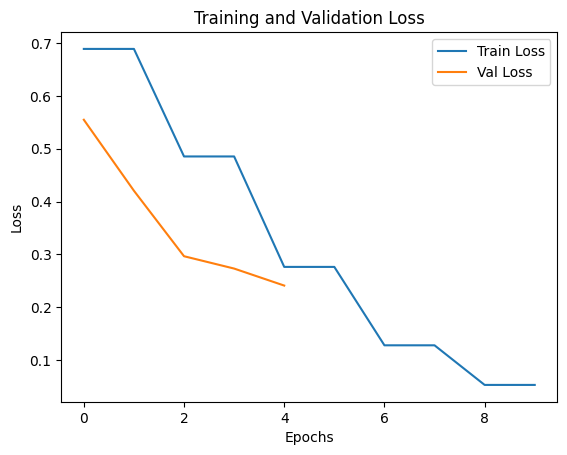

Fold 1
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |    Va     |  Elapsed 
--------------------------------------------------------------------------------
   1    |   20    |   0.988542   |     -      |     -     |   11.98  
   1    |   40    |   0.873929   |     -      |     -     |   11.66  
   1    |   60    |   0.933215   |     -      |     -     |   11.49  
   1    |   80    |   0.860772   |     -      |     -     |   11.49  
   1    |   100   |   0.852245   |     -      |     -     |   11.50  
   1    |   120   |   0.856617   |     -      |     -     |   11.48  
   1    |   140   |   0.776832   |     -      |     -     |   11.46  
   1    |   160   |   0.743703   |     -      |     -     |   11.65  
   1    |   180   |   0.732439   |     -      |     -     |   11.62  
   1    |   200   |   0.687480   |     -      |     -     |   11.57  
   1    |   220   |   0.684656   |     -      |     -     |

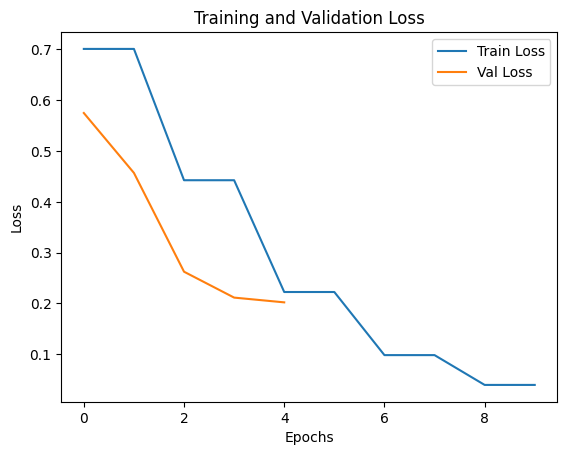

Fold 2
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |    Va     |  Elapsed 
--------------------------------------------------------------------------------
   1    |   20    |   0.971991   |     -      |     -     |   11.85  
   1    |   40    |   0.895415   |     -      |     -     |   11.35  
   1    |   60    |   0.933507   |     -      |     -     |   11.36  
   1    |   80    |   0.845167   |     -      |     -     |   11.40  
   1    |   100   |   0.818572   |     -      |     -     |   11.43  
   1    |   120   |   0.850168   |     -      |     -     |   11.40  
   1    |   140   |   0.717703   |     -      |     -     |   11.44  
   1    |   160   |   0.799506   |     -      |     -     |   11.43  
   1    |   180   |   0.678017   |     -      |     -     |   11.42  
   1    |   200   |   0.714423   |     -      |     -     |   11.47  
   1    |   220   |   0.756811   |     -      |     -     |

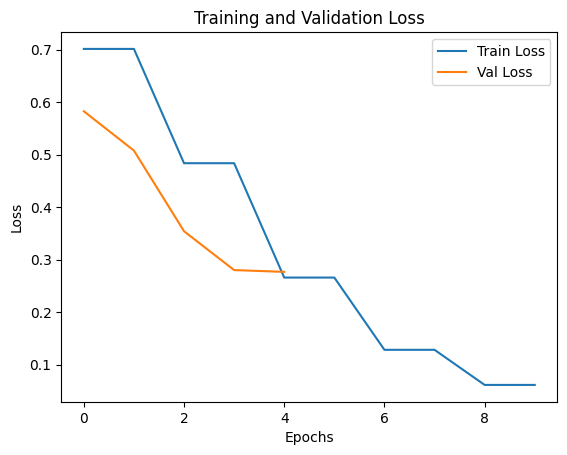

Fold 3
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |    Va     |  Elapsed 
--------------------------------------------------------------------------------
   1    |   20    |   0.983313   |     -      |     -     |   11.93  
   1    |   40    |   0.881079   |     -      |     -     |   11.35  
   1    |   60    |   0.910361   |     -      |     -     |   11.35  
   1    |   80    |   0.814680   |     -      |     -     |   11.37  
   1    |   100   |   0.788151   |     -      |     -     |   11.72  
   1    |   120   |   0.784170   |     -      |     -     |   11.42  
   1    |   140   |   0.726037   |     -      |     -     |   11.45  
   1    |   160   |   0.686453   |     -      |     -     |   11.45  
   1    |   180   |   0.741276   |     -      |     -     |   11.46  
   1    |   200   |   0.687901   |     -      |     -     |   11.45  
   1    |   220   |   0.799986   |     -      |     -     |

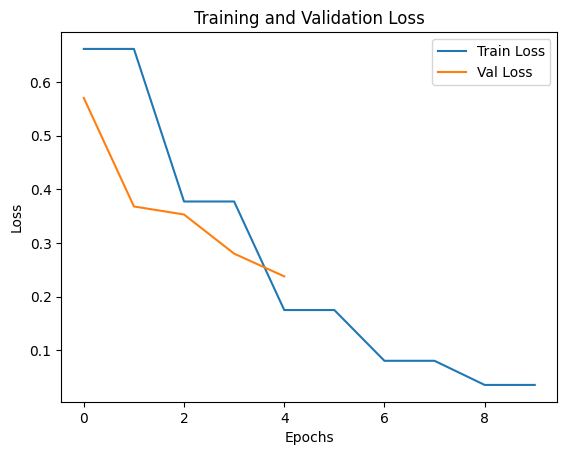

Fold 4
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |    Va     |  Elapsed 
--------------------------------------------------------------------------------
   1    |   20    |   0.982003   |     -      |     -     |   11.87  
   1    |   40    |   0.909789   |     -      |     -     |   11.38  
   1    |   60    |   0.914892   |     -      |     -     |   11.38  
   1    |   80    |   0.858023   |     -      |     -     |   11.44  
   1    |   100   |   0.860813   |     -      |     -     |   11.42  
   1    |   120   |   0.810547   |     -      |     -     |   11.45  
   1    |   140   |   0.817771   |     -      |     -     |   11.45  
   1    |   160   |   0.835641   |     -      |     -     |   11.46  
   1    |   180   |   0.724677   |     -      |     -     |   11.42  
   1    |   200   |   0.792825   |     -      |     -     |   11.44  
   1    |   220   |   0.798591   |     -      |     -     |

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
batch_size = 16
Epoch = 5

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_val_loss = float('inf')
best_macro_f1 = 0.0
best_model = None

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, train_labels)):
    bert_model = BertModel.from_pretrained("hfl/chinese-macbert-large")
    print(f"Fold {fold}")
    fold_performance = []
    fold_metrics = []
    # Create the DataLoader for our training set
    train_data = TensorDataset(train_inputs[train_idx], train_masks[train_idx], train_token_type_ids[train_idx],
                               train_labels[train_idx])
    train_sampler = RandomSampler(train_data)  # No adjust weight
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create the DataLoader for our validation set
    val_data = TensorDataset(train_inputs[val_idx], train_masks[val_idx], train_token_type_ids[val_idx],
                             train_labels[val_idx])
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    %time
    set_seed(42)  # Set seed for reproducibility
    bert_classifier, optimizer, scheduler = initialize_model(epochs=Epoch)
    val_loss, macro_f1= train(bert_classifier, train_dataloader, val_dataloader, epochs=Epoch, evaluation=True, save_best_model = True)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = bert_classifier.state_dict()

    # Check if the current validation accuracy is better than the best validation accuracy
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1

# Save the best model
if best_model is not None:
    torch.save(best_model, f"./final_github/best_model.pt")

# Predict

In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """            
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_token_type_ids = tuple(t.to(device) for t in batch)[:3]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask, b_token_type_ids)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
                                    
    return probs

In [ ]:
test_text_df = df_test[['text1','text2','combined_text']]
test_label = df_test["label"].values
y_test = test_label
test_inputs, test_masks,test_token_type_ids = preprocessing_for_bert(test_text_df)
test_data = TensorDataset(test_inputs, test_masks, test_token_type_ids)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)

In [ ]:
# Compute predicted probabilities on the test set
all_prob = []
all_answer = []

label_folder_name = './final_github'

if not os.path.exists(label_folder_name):
    os.makedirs(label_folder_name)

best_model = bert_classifier
best_model.load_state_dict(torch.load(f"./final_github/best_model.pt"))
best_model.to(device)

probs = bert_predict(best_model, test_dataloader)

all_prob.extend(probs)

val_preds = np.argmax(probs, axis=1)

fold_metrics = {
    'predicted_probs 0': [lst[0] for lst in probs],
    'predicted_probs 1': [lst[1] for lst in probs],
    'predicted_probs 2': [lst[2] for lst in probs],
    'predicted_label': val_preds,
    'true_label': y_test
}

fold_df = pd.DataFrame(fold_metrics, columns=['predicted_probs 0', 'predicted_probs 1',
                                              'predicted_probs 2', 'predicted_label', 'true_label'])

label_file_path = os.path.join(label_folder_name, f'./label.csv')
fold_df.to_csv(label_file_path, index=False)

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

def calculate_metrics(y_true, y_pred):
    prediction = y_pred
    merged_list = y_true

    report = classification_report(merged_list, prediction, digits=4)
    matrix = confusion_matrix(merged_list, prediction)
    f1_score_micro = metrics.f1_score(merged_list, prediction, average='micro')
    f1_score_macro = metrics.f1_score(merged_list, prediction, average='macro')
    precision = precision_score(merged_list, prediction, average='macro')
    recall = recall_score(merged_list, prediction, average='macro')
    accuracy = accuracy_score(merged_list, prediction)

    tn = matrix[0, 0]
    tp = matrix[1, 1]
    fp = matrix[0, 1]
    fn = matrix[1, 0]
    specificity = tn / (fp + tn)
    NPV = tn / (fn + tn)
    PPV = tp / (fp + tp)
    
    results = {
        'report': report,
        'confusion_matrix': matrix,
        'f1_score_micro': f1_score_micro,
        'f1_score_macro': f1_score_macro,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'specificity': specificity,
        'NPV': NPV,
        'PPV': PPV
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1_macro: {f1_score_macro:.4f}")
    print(f"F1_micro: {f1_score_micro:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Sensitivity: {recall:.4f}")
    print(f"PPV: {PPV:.4f}")
    print(f"NPV: {NPV:.4f}")
    print("=============================")
    print("Classification Report: \n", report)
    print("=============================")
    print("Confusion Matrix: \n", matrix)
    
    return results

metrics_results = calculate_metrics(y_test, val_preds)

# VOTING

In [1]:
import pandas as pd
MODEL1_PREDICTION = pd.read_csv("YOUR_MODEL_PREDICTION1.csv")
MODEL2_PREDICTION = pd.read_csv("YOUR_MODEL_PREDICTION2.csv")

,predicted_probs 0,predicted_probs 1,predicted_probs 2,predicted_label,true_label
0,0.999909,0.000048,0.000043,0,0
1,0.002766,0.000417,0.996817,2,0
2,0.999903,0.000054,0.000043,0,0
3,0.999904,0.000051,0.000045,0,0
4,0.999896,0.000059,0.000045,0,0
...,...,...,...,...,...
810,0.000114,0.000206,0.999680,2,2
811,0.000137,0.000198,0.999665,2,2
812,0.000109,0.000130,0.999761,2,2
813,0.001200,0.988153,0.010647,1,2


In [5]:
# combine models
COMBINED_PREDICTION = pd.concat([MODEL1_PREDICTION, MODEL2_PREDICTION], axis=1)

# COUNT AVERAGE SCORE
VOTING_RESULT = COMBINED_PREDICTION.groupby(COMBINED_PREDICTION.columns, axis=1).mean()

# FIND THE MAX LABEL
VOTING_RESULT['pred_label'] = VOTING_RESULT.idxmax(axis=1)
VOTING_RESULT = VOTING_RESULT.assign(max_value=VOTING_RESULT.max(axis=1))
VOTING_RESULT

,0,1,2,predicted_label,0,1,2,predicted_label
0,0.994784,0.002090,0.003126,0,0.999909,0.000048,0.000043,0
1,0.992884,0.002964,0.004152,0,0.002766,0.000417,0.996817,2
2,0.949551,0.016801,0.033648,0,0.999903,0.000054,0.000043,0
3,0.993959,0.002336,0.003705,0,0.999904,0.000051,0.000045,0
4,0.993920,0.002355,0.003724,0,0.999896,0.000059,0.000045,0
...,...,...,...,...,...,...,...,...
810,0.016422,0.262538,0.721040,2,0.000114,0.000206,0.999680,2
811,0.013949,0.357227,0.628825,2,0.000137,0.000198,0.999665,2
812,0.035288,0.310709,0.654003,2,0.000109,0.000130,0.999761,2
813,0.022725,0.297593,0.679682,2,0.001200,0.988153,0.010647,1
